In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-to-mri-cgan/Dataset/sources.txt
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1860.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1979.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri99.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri478.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1608.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1379.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2058.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1589.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri678.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2440.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri959.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri750.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1628.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2288.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri699.jpg
/kaggle/input/ct-to-mri-cgan

In [2]:
# ===============================================================
# Install dependencies 
# ===============================================================
try:
    import lpips, pytorch_fid
except Exception:
    !pip install --quiet lpips pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency re

In [3]:
# 1) Imports & Config
# -------------------------
import os, glob, csv, time, itertools, math
from datetime import timedelta
from PIL import Image
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from pytorch_fid import fid_score
from lpips import LPIPS
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Repro
torch.backends.cudnn.benchmark = True

In [4]:
# -------------------------
# 2) Paths
# -------------------------
DATA_ROOT = "/kaggle/input/ct-to-mri-cgan/Dataset/images"
CT_TRAIN = os.path.join(DATA_ROOT, "trainA")   # CT images
MRI_TRAIN = os.path.join(DATA_ROOT, "trainB")  # MRI images
CT_TEST  = os.path.join(DATA_ROOT, "testA")
MRI_TEST = os.path.join(DATA_ROOT, "testB")

OUT_DIR = "outputs_ct2mri"
CKPT_DIR = os.path.join(OUT_DIR, "checkpoints")
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
XAI_DIR = os.path.join(OUT_DIR, "xai")
GEN_DIR = os.path.join(OUT_DIR, "generated_ct2mri")
REAL_FOR_FID = os.path.join(OUT_DIR, "real_mri_for_fid")

for d in [OUT_DIR, CKPT_DIR, PLOTS_DIR, XAI_DIR, GEN_DIR, REAL_FOR_FID]:
    os.makedirs(d, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {DEVICE}")

 Using device: cuda


In [5]:
# -------------------------
# 3) Hyperparams
# -------------------------
IMAGE_SIZE = 256
BATCH_SIZE = 2
EPOCHS = 100
LR = 1e-4
BETA1, BETA2 = 0.5, 0.999
SAVE_EVERY = 10

lambda_cyc = 10.0
lambda_id  = 5.0
lambda_cut = 1.0


In [6]:
# -------------------------
# 4) Dataset & Transforms
# -------------------------
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.Grayscale(),                 # force grayscale
    T.ToTensor(),
    T.Normalize([0.5], [0.5])      # [-1, 1]
])

class CTMRIDataset(Dataset):
    def __init__(self, ct_dir, mri_dir):
        exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
        self.ct_paths = []
        self.mri_paths = []
        for e in exts:
            self.ct_paths += glob.glob(os.path.join(ct_dir, e))
            self.mri_paths += glob.glob(os.path.join(mri_dir, e))
        self.ct_paths = sorted(self.ct_paths)
        self.mri_paths = sorted(self.mri_paths)
        self.length = min(len(self.ct_paths), len(self.mri_paths))

    def __len__(self): return self.length

    def __getitem__(self, idx):
        ct_img  = Image.open(self.ct_paths[idx]).convert('L')
        mri_img = Image.open(self.mri_paths[idx]).convert('L')
        return transform(ct_img), transform(mri_img)

train_ds = CTMRIDataset(CT_TRAIN, MRI_TRAIN)
dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
print(f" Train pairs: {len(train_ds)}")


 Train pairs: 1742


In [7]:
# -------------------------
# 5) Model (HybridCycleCUT)
# -------------------------
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x): return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, n_res=9, base=32):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, base, 7),
            nn.InstanceNorm2d(base), nn.ReLU(True),
            nn.Conv2d(base, base*2, 3, 2, 1),
            nn.InstanceNorm2d(base*2), nn.ReLU(True),
            nn.Conv2d(base*2, base*4, 3, 2, 1),
            nn.InstanceNorm2d(base*4), nn.ReLU(True),
        ]
        for _ in range(n_res):
            model += [ResBlock(base*4)]
        model += [
            nn.ConvTranspose2d(base*4, base*2, 3, 2, 1, 1),
            nn.InstanceNorm2d(base*2), nn.ReLU(True),
            nn.ConvTranspose2d(base*2, base, 3, 2, 1, 1),
            nn.InstanceNorm2d(base), nn.ReLU(True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(base, out_ch, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x): return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_ch=1, base=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, base, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=False), 
            nn.Conv2d(base, base*2, 4, 2, 1),
            nn.InstanceNorm2d(base*2),
            nn.LeakyReLU(0.2, inplace=False),  # 👈 changed
            nn.Conv2d(base*2, base*4, 4, 2, 1),
            nn.InstanceNorm2d(base*4),
            nn.LeakyReLU(0.2, inplace=False),  # 👈 changed
            nn.Conv2d(base*4, 1, 4, 1, 1)
        )
    def forward(self, x): return self.model(x)

class MLP(nn.Module):
    def __init__(self, dim=128):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(dim, dim), nn.ReLU(True),
            nn.Linear(dim, dim)
        )
    def forward(self, x): return self.layer(x)

class HybridCycleCUT(nn.Module):
    def __init__(self):
        super().__init__()
        self.G_A2B = Generator()  # CT → MRI
        self.G_B2A = Generator()  # MRI → CT
        self.D_A = Discriminator()
        self.D_B = Discriminator()
        self.mlp = MLP(dim=128)

    def _feat_early(self, x, gen):
        # take features right after the second downsample (C=128 at 1/4 res)
        feats = []
        for i, layer in enumerate(gen.model):
            x = layer(x)
            # After third element block: conv->inorm->relu (index up to ~8) we are at 1/4
            feats.append(x)
            # capture at index where channels==128
        # find earliest 128C map (heuristic)
        for f in feats:
            if f.dim()==4 and f.shape[1]==128:
                return f
        return feats[-1]

    def forward(self, real_A, real_B):
        fake_B = self.G_A2B(real_A)
        fake_A = self.G_B2A(real_B)
        rec_A  = self.G_B2A(fake_B)
        rec_B  = self.G_A2B(fake_A)

        # CUT features (project patches)
        feat_real_A = self._feat_early(real_A, self.G_B2A)  # use opposite net to compare
        feat_fake_B = self._feat_early(fake_B, self.G_B2A)
        feat_real_B = self._feat_early(real_B, self.G_A2B)
        feat_fake_A = self._feat_early(fake_A, self.G_A2B)

        def proj(f):  # (B,C,H,W)->(B,N,128)
            B,C,H,W = f.shape
            f = f.view(B, C, H*W).permute(0,2,1)  # (B,N,C)
            return self.mlp(f)
        return fake_B, fake_A, rec_A, rec_B, proj(feat_real_A), proj(feat_fake_B), proj(feat_real_B), proj(feat_fake_A)

model = HybridCycleCUT().to(DEVICE)


In [8]:
# -------------------------
# 6) Losses & Opts
# -------------------------
criterionGAN = nn.MSELoss()
criterionL1  = nn.L1Loss()

def gan_loss(pred, target=True):
    return criterionGAN(pred, torch.ones_like(pred) if target else torch.zeros_like(pred))

def patchnce_loss(f_s, f_t, tau=0.07):
    # f_s,f_t: (B,N,D)
    f_s = F.normalize(f_s, dim=-1)
    f_t = F.normalize(f_t, dim=-1)
    sim = torch.bmm(f_s, f_t.transpose(1,2)) / tau  # (B,N,N)
    labels = torch.arange(f_s.size(1), device=f_s.device).expand(f_s.size(0), -1)
    return F.cross_entropy(sim, labels)

opt_G = optim.Adam(itertools.chain(model.G_A2B.parameters(), model.G_B2A.parameters(), model.mlp.parameters()), lr=LR, betas=(BETA1,BETA2))
opt_D = optim.Adam(itertools.chain(model.D_A.parameters(), model.D_B.parameters()), lr=LR, betas=(BETA1,BETA2))

scaler = torch.cuda.amp.GradScaler()


/tmp/ipykernel_37/3062735720.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [9]:
# -------------------------
# 7) Logging CSV
# -------------------------
metrics_csv = os.path.join(OUT_DIR, "training_log.csv")
with open(metrics_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch','G_GAN','G_Cycle','G_Id','G_CUT','G_total','D_real','D_fake','D_total','lr','time_sec'])



In [10]:
# -------------------------
# 8) Training Loop (100 epochs) with ETA
# -------------------------
print(" Starting training...")

start_time_all = time.time()
epoch_times = []

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    meter_G_GAN = meter_G_Cycle = meter_G_Id = meter_G_CUT = meter_G = 0.0
    meter_D_real = meter_D_fake = meter_D = 0.0
    n_samples = 0

    model.train()
    for real_A, real_B in dataloader:
        real_A, real_B = real_A.to(DEVICE), real_B.to(DEVICE)
        bs = real_A.size(0)

        with torch.cuda.amp.autocast():
            (fake_B, fake_A, rec_A, rec_B,
             proj_real_A, proj_fake_B, proj_real_B, proj_fake_A) = model(real_A, real_B)

            # Discriminator
            D_A_real = gan_loss(model.D_A(real_A), True)
            D_A_fake = gan_loss(model.D_A(fake_A.detach()), False)
            D_B_real = gan_loss(model.D_B(real_B), True)
            D_B_fake = gan_loss(model.D_B(fake_B.detach()), False)
            loss_D = 0.5*(D_A_real + D_A_fake) + 0.5*(D_B_real + D_B_fake)

        opt_D.zero_grad()
        scaler.scale(loss_D).backward()
        scaler.step(opt_D)

        with torch.cuda.amp.autocast():
            # Generator
            G_A = gan_loss(model.D_A(fake_A), True)
            G_B = gan_loss(model.D_B(fake_B), True)
            loss_G_GAN = 0.5*(G_A + G_B)

            loss_cycle = criterionL1(rec_A, real_A) + criterionL1(rec_B, real_B)
            loss_id    = criterionL1(model.G_B2A(real_A), real_A) + criterionL1(model.G_A2B(real_B), real_B)

            loss_cut = patchnce_loss(proj_real_A, proj_fake_B) + patchnce_loss(proj_real_B, proj_fake_A)

            loss_G = loss_G_GAN + lambda_cyc*loss_cycle + lambda_id*loss_id + lambda_cut*loss_cut

        opt_G.zero_grad()
        scaler.scale(loss_G).backward()
        scaler.step(opt_G)
        scaler.update()

        # meters
        meter_G_GAN   += loss_G_GAN.item()*bs
        meter_G_Cycle += loss_cycle.item()*bs
        meter_G_Id    += loss_id.item()*bs
        meter_G_CUT   += loss_cut.item()*bs
        meter_G       += loss_G.item()*bs
        meter_D_real  += (D_A_real + D_B_real).item()*bs
        meter_D_fake  += (D_A_fake + D_B_fake).item()*bs
        meter_D       += loss_D.item()*bs
        n_samples     += bs

    # averages
    meter_G_GAN   /= n_samples
    meter_G_Cycle /= n_samples
    meter_G_Id    /= n_samples
    meter_G_CUT   /= n_samples
    meter_G       /= n_samples
    meter_D_real  /= n_samples
    meter_D_fake  /= n_samples
    meter_D       /= n_samples

    t1 = time.time()
    epoch_time = t1 - t0
    epoch_times.append(epoch_time)
    avg_epoch = np.mean(epoch_times)
    remaining = (EPOCHS - epoch) * avg_epoch
    # Pretty formats
    def fmt_secs(s): 
        return f"{int(s//3600)}h{int((s%3600)//60)}m" if s>=3600 else (f"{int(s//60)}m{int(s%60)}s" if s>=60 else f"{s:.1f}s")

    log_line = (f"Epoch {epoch:3d} | G:{meter_G:.4f} | D:{meter_D:.4f} | "
                f"GAN:{meter_G_GAN:.4f} | Cyc:{meter_G_Cycle:.4f} | Id:{meter_G_Id:.4f} | CUT:{meter_G_CUT:.4f} | "
                f"Time:{fmt_secs(epoch_time)} | ETA:{fmt_secs(remaining)}")
    print(log_line)

    # CSV
    with open(metrics_csv, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch, f"{meter_G_GAN:.6f}", f"{meter_G_Cycle:.6f}", f"{meter_G_Id:.6f}", f"{meter_G_CUT:.6f}",
            f"{meter_G:.6f}", f"{meter_D_real:.6f}", f"{meter_D_fake:.6f}", f"{meter_D:.6f}",
            f"{opt_G.param_groups[0]['lr']:.6f}", f"{epoch_time:.3f}"
        ])

    # checkpoints
    if epoch % SAVE_EVERY == 0 or epoch == EPOCHS:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'opt_G': opt_G.state_dict(),
            'opt_D': opt_D.state_dict(),
        }, os.path.join(CKPT_DIR, f'ct2mri_hybrid_epoch_{epoch}.pth'))

total_time = time.time() - start_time_all
print(f" Training complete in {int(total_time//60)}m {int(total_time%60)}s.")

 Starting training...


/tmp/ipykernel_37/571432996.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_37/571432996.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch   1 | G:10.4413 | D:0.2764 | GAN:0.6036 | Cyc:0.2041 | Id:0.1893 | CUT:6.8504 | Time:4m31s | ETA:7h27m
Epoch   2 | G:8.3574 | D:0.2156 | GAN:0.6955 | Cyc:0.1572 | Id:0.1453 | CUT:5.3635 | Time:4m27s | ETA:7h19m
Epoch   3 | G:7.9402 | D:0.2062 | GAN:0.7123 | Cyc:0.1432 | Id:0.1301 | CUT:5.1450 | Time:4m27s | ETA:7h14m
Epoch   4 | G:7.6900 | D:0.2104 | GAN:0.6959 | Cyc:0.1351 | Id:0.1203 | CUT:5.0413 | Time:4m27s | ETA:7h9m
Epoch   5 | G:7.5077 | D:0.1926 | GAN:0.7236 | Cyc:0.1245 | Id:0.1100 | CUT:4.9889 | Time:4m27s | ETA:7h4m
Epoch   6 | G:7.3547 | D:0.1864 | GAN:0.7346 | Cyc:0.1169 | Id:0.1030 | CUT:4.9364 | Time:4m27s | ETA:6h59m
Epoch   7 | G:7.2723 | D:0.1773 | GAN:0.7454 | Cyc:0.1128 | Id:0.0982 | CUT:4.9076 | Time:4m27s | ETA:6h55m
Epoch   8 | G:7.2011 | D:0.1713 | GAN:0.7577 | Cyc:0.1092 | Id:0.0955 | CUT:4.8743 | Time:4m27s | ETA:6h50m
Epoch   9 | G:7.1206 | D:0.1757 | GAN:0.7525 | Cyc:0.1051 | Id:0.0914 | CUT:4.8597 | Time:4m27s | ETA:6h46m
Epoch  10 | G:7.0767 | D:0.17

In [11]:
# -------------------------
# 9) Inference on testA (CT→MRI)
# -------------------------
model.eval()
test_paths = []
for e in ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff"):
    test_paths += glob.glob(os.path.join(CT_TEST, e))
test_paths = sorted(test_paths)

for p in tqdm(test_paths, desc="Generating MRI"):
    img = transform(Image.open(p).convert('L')).unsqueeze(0).to(DEVICE)
    with torch.no_grad(), torch.cuda.amp.autocast():
        fake = model.G_A2B(img)
    save_image((fake+1)/2, os.path.join(GEN_DIR, os.path.basename(p)))

print(" Generated images:", GEN_DIR)


Generating MRI:   0%|          | 0/744 [00:00<?, ?it/s]/tmp/ipykernel_37/1416006743.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Generating MRI: 100%|██████████| 744/744 [00:30<00:00, 24.14it/s]

 Generated images: outputs_ct2mri/generated_ct2mri


In [12]:
# -------------------------
# 10) Metrics (ALL test images)
# -------------------------
# Prepare real MRI folder for FID to ensure clean set
# (copy/resize testB images to REAL_FOR_FID to avoid surprises)
def copy_resized(src_dir, dst_dir):
    # clean dst
    for f in glob.glob(os.path.join(dst_dir, "*")):
        try: os.remove(f)
        except: pass
    paths = []
    for e in ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff"):
        paths += glob.glob(os.path.join(src_dir, e))
    paths = sorted(paths)
    for i, p in enumerate(paths):
        im = Image.open(p).convert('L').resize((IMAGE_SIZE, IMAGE_SIZE))
        im.save(os.path.join(dst_dir, f"real_{i:05d}.png"))

copy_resized(MRI_TEST, REAL_FOR_FID)

# FID
try:
    fid_val = fid_score.calculate_fid_given_paths([REAL_FOR_FID, GEN_DIR], batch_size=16, device=DEVICE, dims=2048)
    print(f"FID: {fid_val:.4f}")
except Exception as e:
    print("FID failed:", e)
    fid_val = "N/A"

# LPIPS / PSNR / SSIM / MSE / RMSE on index-aligned pairs (min length)
fake_paths = sorted(glob.glob(os.path.join(GEN_DIR, "*")))
real_paths = sorted(glob.glob(os.path.join(REAL_FOR_FID, "*")))
n_eval = min(len(fake_paths), len(real_paths))
print(f"Evaluating IQA on {n_eval} pairs ...")

lpips_model = LPIPS(net='vgg').to(DEVICE).eval()

s_lpips = s_psnr = s_ssim = s_mse = s_rmse = 0.0
for i in tqdm(range(n_eval), desc="IQA"):
    f_img = Image.open(fake_paths[i]).convert('L')
    r_img = Image.open(real_paths[i]).convert('L')

    # tensors in [-1,1] for LPIPS (to match earlier convention)
    f_t = T.ToTensor()(f_img).unsqueeze(0).to(DEVICE) * 2 - 1
    r_t = T.ToTensor()(r_img).unsqueeze(0).to(DEVICE) * 2 - 1

    with torch.no_grad():
        s_lpips += lpips_model(f_t, r_t).item()

    # for PSNR/SSIM use [0,1]
    f_np = (f_t.squeeze().detach().cpu().numpy()*0.5 + 0.5)
    r_np = (r_t.squeeze().detach().cpu().numpy()*0.5 + 0.5)

    s_psnr += psnr(r_np, f_np, data_range=1.0)
    s_ssim += ssim(r_np, f_np, data_range=1.0)
    mse_val = np.mean((f_np - r_np)**2)
    s_mse  += mse_val
    s_rmse += math.sqrt(mse_val)

metrics = {
    'fid': fid_val if isinstance(fid_val, float) else 'N/A',
    'lpips': s_lpips/n_eval if n_eval>0 else 'N/A',
    'psnr': s_psnr/n_eval if n_eval>0 else 'N/A',
    'ssim': s_ssim/n_eval if n_eval>0 else 'N/A',
    'rmse': s_rmse/n_eval if n_eval>0 else 'N/A',
    'mse' : s_mse/n_eval if n_eval>0 else 'N/A',
}
print("Final metrics:", metrics)

# Save metrics CSV and append to last row of training log
final_csv = os.path.join(OUT_DIR, "final_metrics.csv")
with open(final_csv, 'w', newline='') as f:
    writer = csv.writer(f); writer.writerow(metrics.keys()); writer.writerow(metrics.values())

# Update last row in training_log.csv
import pandas as pd
df = pd.read_csv(metrics_csv)
last_epoch = df['epoch'].iloc[-1]
for k in metrics.keys():
    if k not in df.columns:
        df[k] = ""
df.loc[df['epoch']==last_epoch, list(metrics.keys())] = list(metrics.values())
df.to_csv(metrics_csv, index=False)


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 328MB/s]
100%|██████████| 47/47 [00:02<00:00, 18.84it/s]


FID: 104.2735
Evaluating IQA on 744 pairs ...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


IQA: 100%|██████████| 744/744 [00:14<00:00, 49.65it/s]

Final metrics: {'fid': 104.27346912953885, 'lpips': 0.49387898159924376, 'psnr': 12.532815845165421, 'ssim': 0.25954362418388666, 'rmse': 0.24630989781120888, 'mse': 0.06598495346398883}


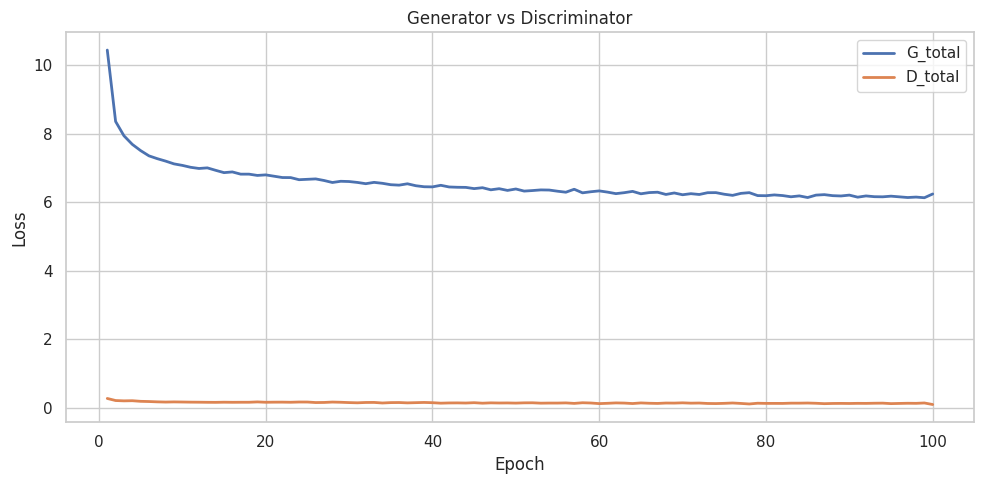

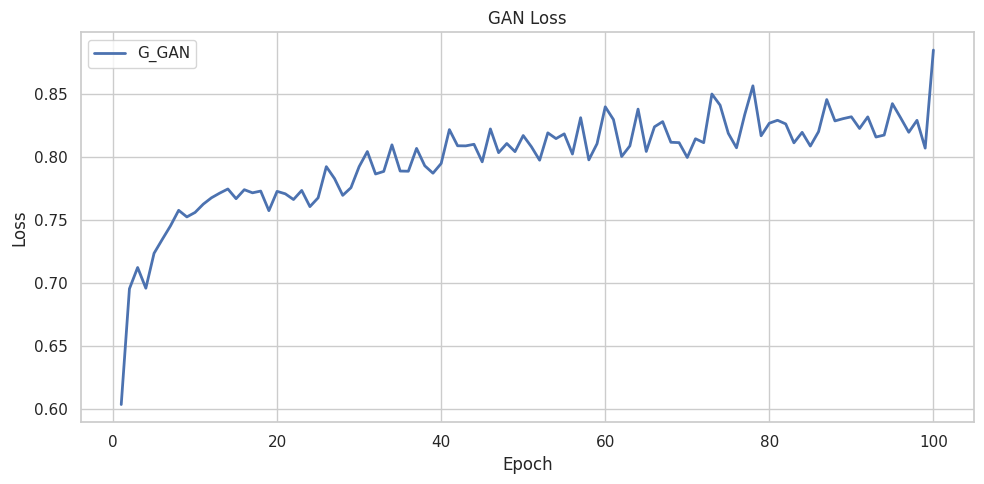

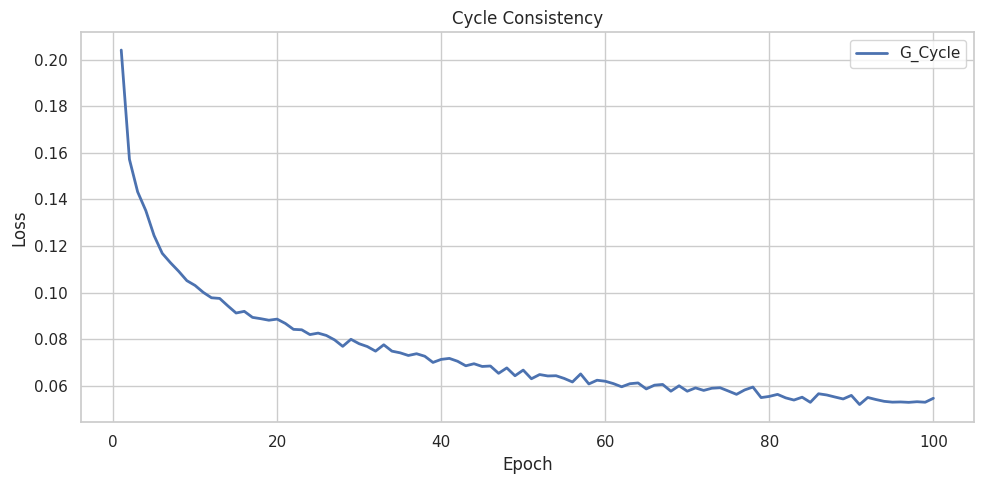

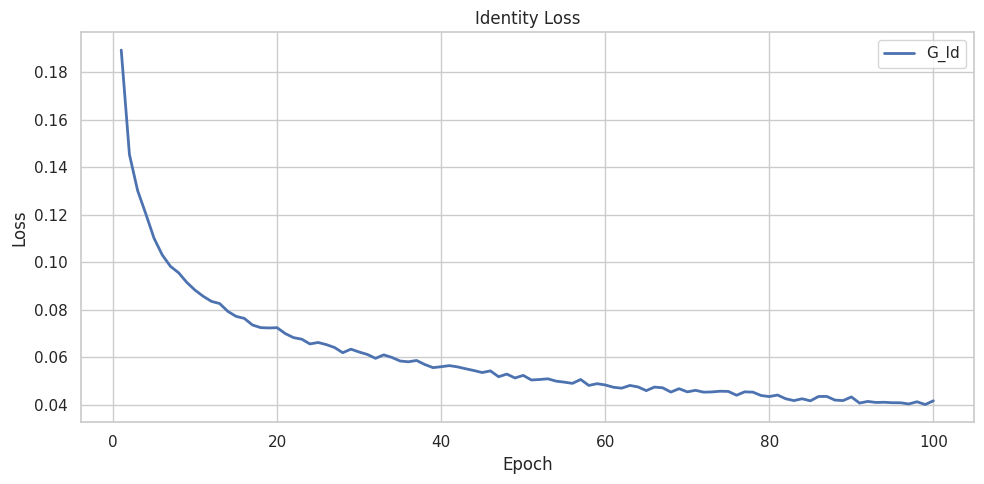

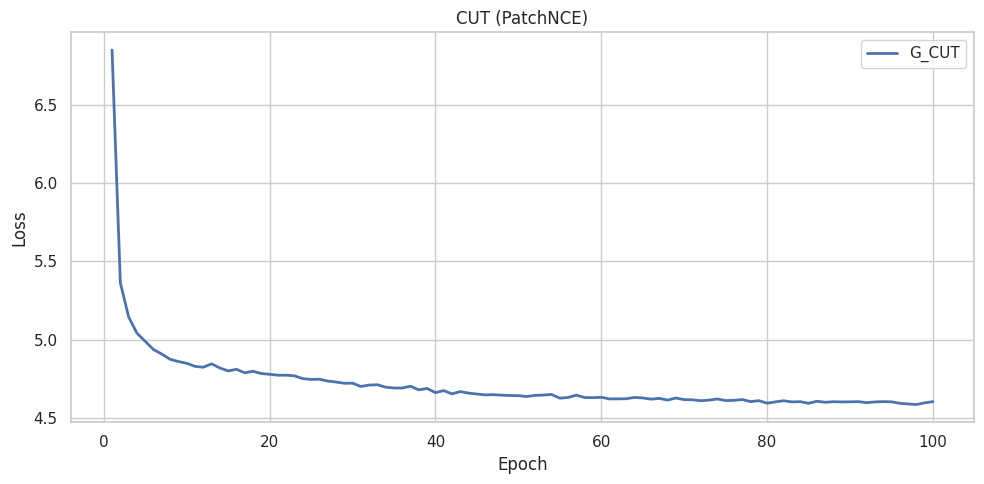

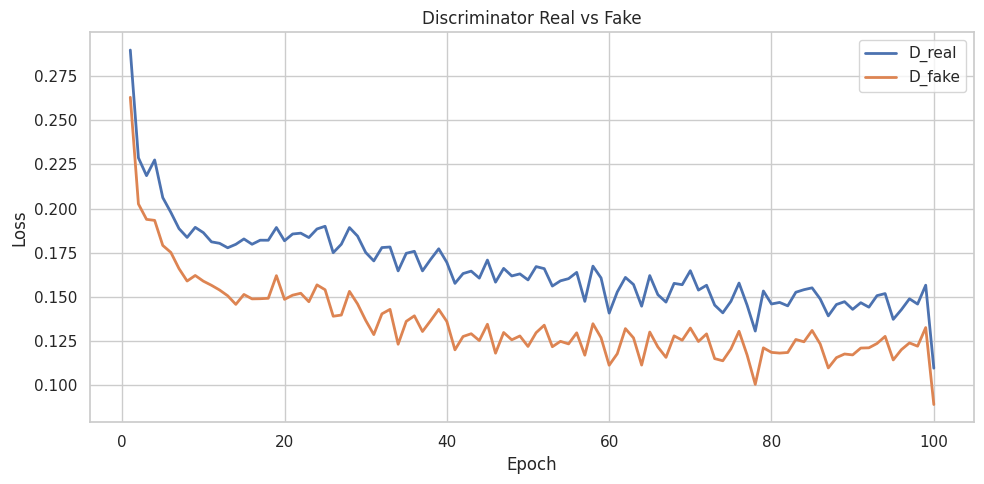

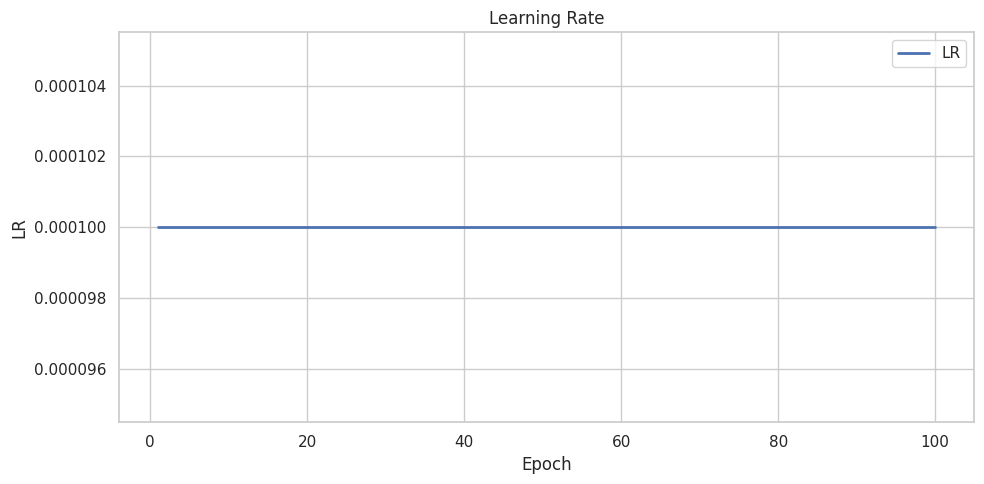

In [13]:
# -------------------------
# 11) Plots
# -------------------------
df = pd.read_csv(metrics_csv)
for col in ['G_total','D_total','G_GAN','G_Cycle','G_Id','G_CUT','D_real','D_fake','lr','time_sec']:
    if col not in df.columns:
        df[col] = 0.0

plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['G_total'], label='G_total', linewidth=2)
plt.plot(df['epoch'], df['D_total'], label='D_total', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Generator vs Discriminator'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,'loss_G_vs_D.png'), dpi=200); plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['G_GAN'], label='G_GAN', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('GAN Loss'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,'loss_GAN.png'), dpi=200); plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['G_Cycle'], label='G_Cycle', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Cycle Consistency'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,'loss_Cycle.png'), dpi=200); plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['G_Id'], label='G_Id', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Identity Loss'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,'loss_Identity.png'), dpi=200); plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['G_CUT'], label='G_CUT', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('CUT (PatchNCE)'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,'loss_CUT.png'), dpi=200); plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['D_real'], label='D_real', linewidth=2)
plt.plot(df['epoch'], df['D_fake'], label='D_fake', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Discriminator Real vs Fake'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,'loss_D_real_fake.png'), dpi=200); plt.show()

plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['lr'], label='LR', linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('LR'); plt.title('Learning Rate'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,'learning_rate.png'), dpi=200); plt.show()


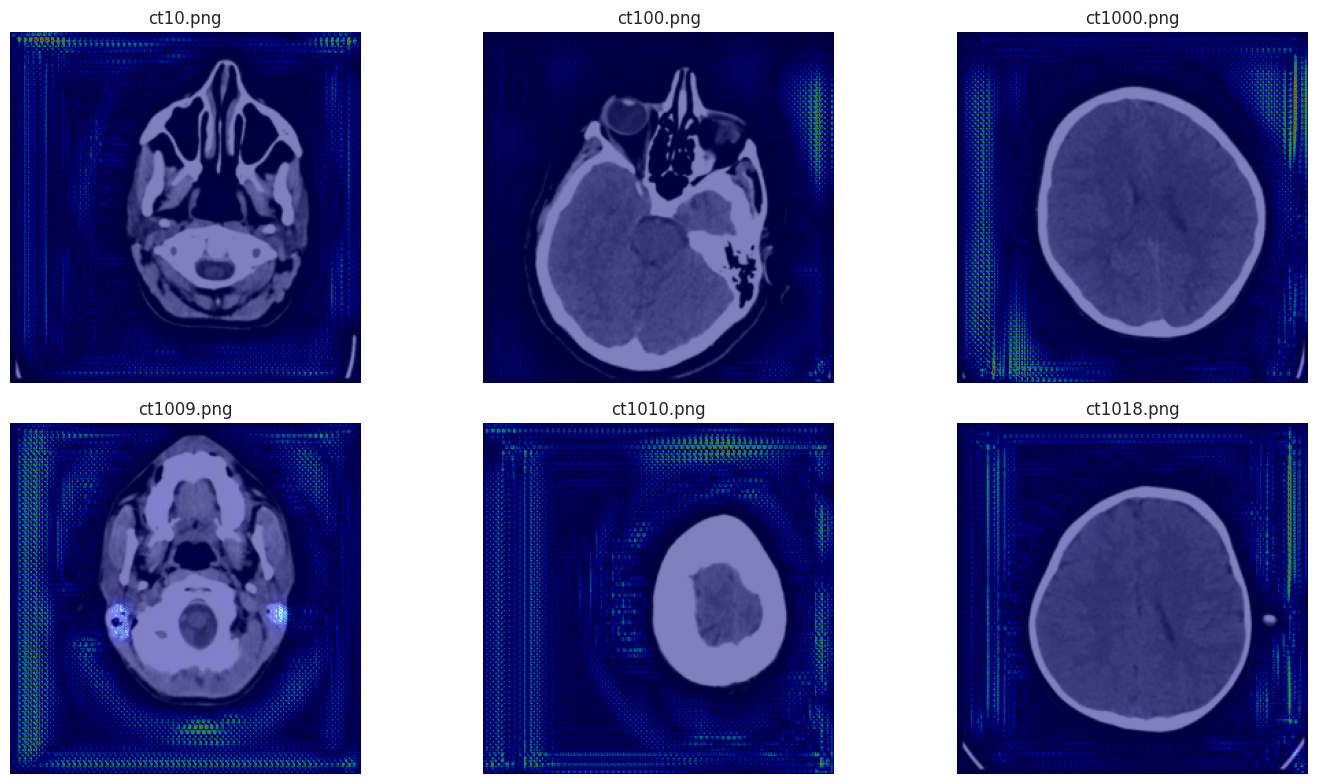

In [14]:
# -------------------------
# 12) Saliency (on G_A2B)
# -------------------------
def compute_saliency(netG, x):
    x = x.clone().detach().requires_grad_(True)
    fake = netG(x)
    score = fake.mean()
    netG.zero_grad()
    score.backward()
    sal = x.grad.abs().sum(1).squeeze().detach().cpu().numpy()
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal

# sample a few testA images
sample_paths = test_paths[:6] if len(test_paths)>=6 else test_paths
fig, axes = plt.subplots(2, max(3,len(sample_paths)//2+len(sample_paths)%2), figsize=(15,8))
axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
for ax, p in zip(axes, sample_paths):
    x = transform(Image.open(p).convert('L')).unsqueeze(0).to(DEVICE)
    sal = compute_saliency(model.G_A2B, x)
    img_np = (x[0].detach().cpu().numpy().transpose(1,2,0)*0.5 + 0.5).squeeze()
    ax.imshow(img_np, cmap='gray')
    ax.imshow(sal, cmap='jet', alpha=0.5)
    ax.set_title(os.path.basename(p)); ax.axis('off')
plt.tight_layout(); plt.savefig(os.path.join(XAI_DIR,'saliency.png'), dpi=200); plt.show()


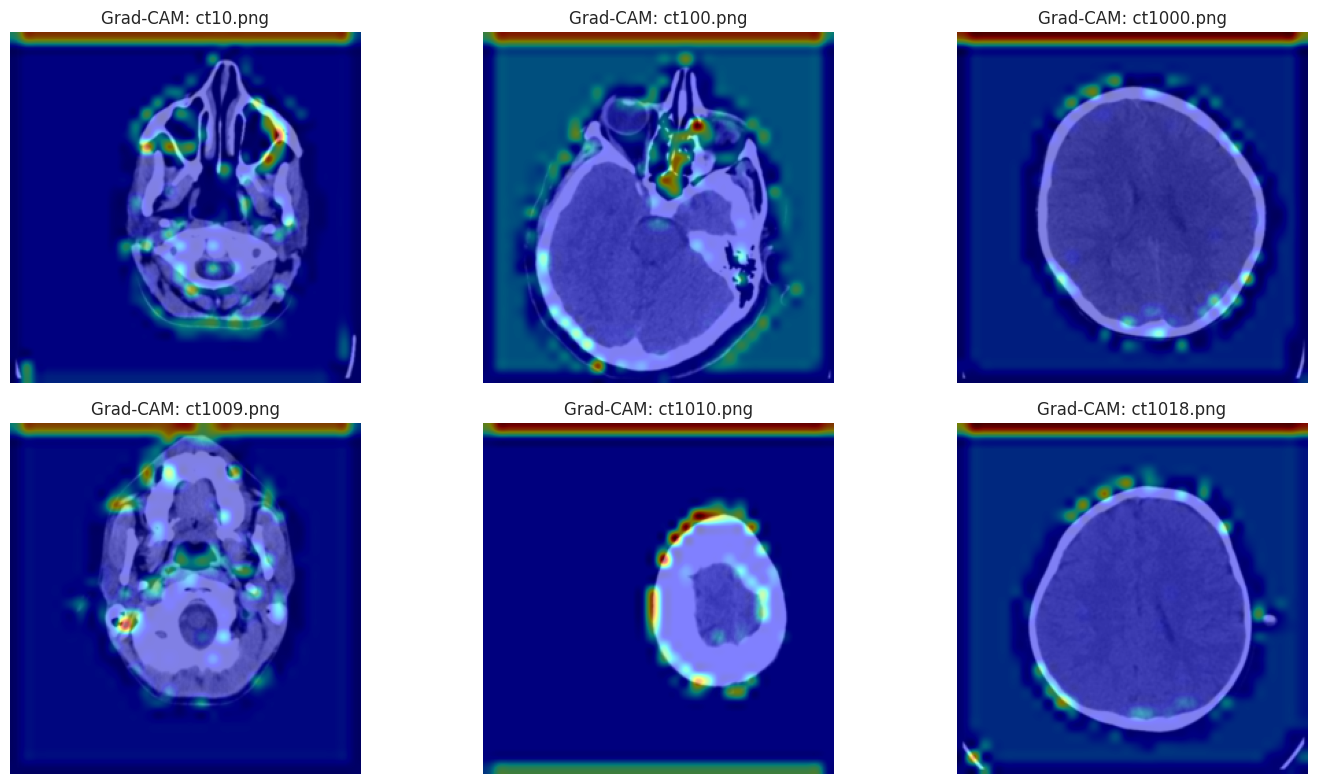

In [15]:
# -------------------------
# 13) Grad-CAM (on D_B) – Safe Version
# -------------------------
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self._feats = None
        self._grads = None
        layer = dict(self.model.named_modules())[self.layer_name]

        # Hooks — clone to avoid in-place gradient conflicts
        def save_feat(module, inp, out):
            self._feats = out.clone().detach().requires_grad_(True)
        def save_grad(module, grad_in, grad_out):
            self._grads = grad_out[0].clone().detach()

        self.h_f = layer.register_forward_hook(save_feat)
        self.h_b = layer.register_full_backward_hook(save_grad)

    def __call__(self, x):
        self.model.zero_grad(set_to_none=True)
        out = self.model(x)
        score = out.mean()
        score.backward(retain_graph=True)

        feats = self._feats
        grads = self._grads
        if feats is None or grads is None:
            raise RuntimeError("GradCAM failed to capture features or gradients.")
        w = grads.mean(dim=(2,3), keepdim=True)
        cam = (feats * w).sum(1).squeeze().detach().cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = np.array(Image.fromarray(cam).resize((IMAGE_SIZE, IMAGE_SIZE)))
        return cam

# pick the same layer as before
db_layers = dict(model.D_B.named_modules())
target_layer = None
for name, m in db_layers.items():
    if isinstance(m, nn.InstanceNorm2d) and m.num_features == 256:
        target_layer = name
if target_layer is None:
    target_layer = 'model.5'

gradcam = GradCAM(model.D_B, target_layer)

# Visualization
fig, axes = plt.subplots(2, max(3, len(sample_paths)//2 + len(sample_paths)%2), figsize=(15,8))
axes = axes.flatten() if hasattr(axes, "flatten") else [axes]
for ax, p in zip(axes, sample_paths):
    x = transform(Image.open(p).convert("L")).unsqueeze(0).to(DEVICE)
    cam = gradcam(x)  # Grad-CAM on D_B(x)
    img_np = (x[0].detach().cpu().numpy().transpose(1,2,0)*0.5 + 0.5).squeeze()
    ax.imshow(img_np, cmap="gray")
    ax.imshow(cam, cmap="jet", alpha=0.5)
    ax.set_title(f"Grad-CAM: {os.path.basename(p)}")
    ax.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(XAI_DIR, "gradcam_fixed.png"), dpi=200)
plt.show()


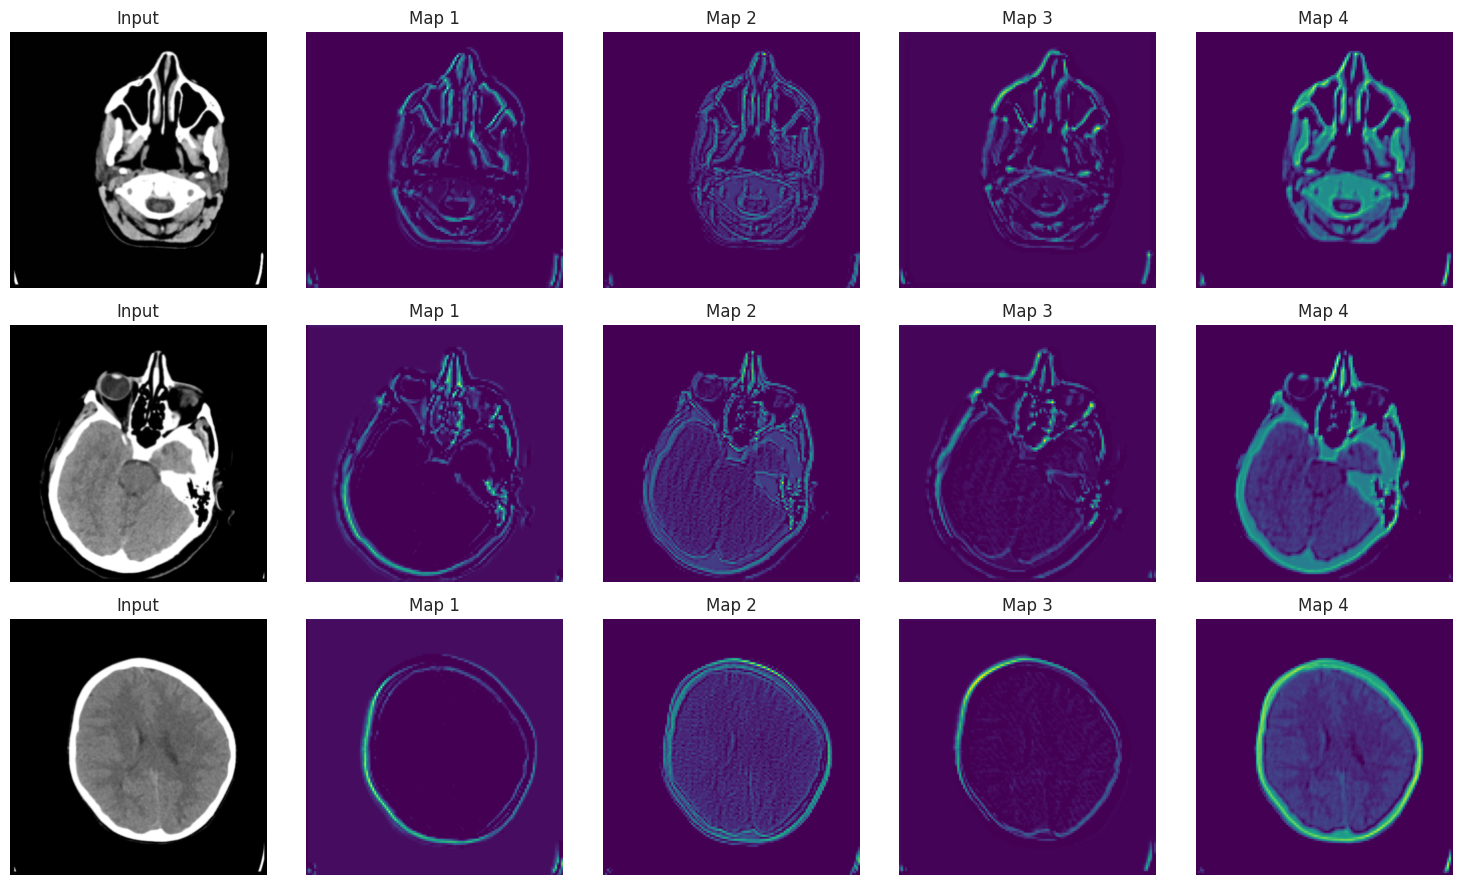

 All done.


In [16]:
# -------------------------
# 14) Feature maps (early layer of G_A2B)
# -------------------------
def visualize_feature_maps(netG, images, layer_idx=5, n_show=4, save_path=None):
    act = {}
    def hook(m, i, o): act['out'] = o.detach()
    layer = list(netG.model.children())[layer_idx]
    handle = layer.register_forward_hook(hook)

    cols = n_show+1
    fig, axes = plt.subplots(len(images), cols, figsize=(3*cols, 3*len(images)))
    if len(images)==1: axes = [axes]
    for r, img in enumerate(images):
        x = transform(Image.open(img).convert('L')).unsqueeze(0).to(DEVICE)
        _ = netG(x)
        fmap = act['out'].cpu().squeeze(0)  # (C,H,W)
        img_np = (x[0].detach().cpu().numpy().transpose(1,2,0)*0.5 + 0.5).squeeze()

        axes[r][0].imshow(img_np, cmap='gray'); axes[r][0].set_title("Input"); axes[r][0].axis('off')
        for j in range(min(n_show, fmap.shape[0])):
            axes[r][1+j].imshow(fmap[j], cmap='viridis'); axes[r][1+j].set_title(f"Map {j+1}"); axes[r][1+j].axis('off')

    handle.remove()
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=200)
    plt.show()

viz_samples = sample_paths[:3] if len(sample_paths)>=3 else sample_paths
visualize_feature_maps(model.G_A2B, viz_samples, layer_idx=5, n_show=4, save_path=os.path.join(XAI_DIR,'feature_maps.png'))

print(" All done.")